**2021/22**

# ML pipeline - use of linear regression
This lecture is about setting up a ML pipeline for data prediction, using linear regression and Spark MLlib.

As mentioned in previous lectures, Apache Spark provides a library for machine learning, with scalability and easy-to-use of uttmost importance. Actually there are two, one is RDD-based and another one is DataFrame-based. We will use the most common MLlib, the DataFrame-based.

Hence, in this notebook, we start by describing MLlib and then focus on solving the ML problem. 


# Spark MLlib

MLlib is a scalable machine learning library that provides a uniform set of high-level APIs that help users create and tune practical ML pipelines.


The MLlib package contain tools such as:
- ML algorithms: common algorithms for clustering, regression, classification, collaborative filtering, etc.
- Featurisation: feature extraction, transformation, dimensionality reduction, selection, etc.
- Pipelines: tools for constructing, evaluating and tuning ML pipelines.
- Persistence: to save and load algoirithms, models and pipelines.
- Utilities: linear algebra, statistics, data handling, etc.

In other words, it provides a uniform set of high-level APIs that help users to create and tune practical ML pipelines. You will find additional details about Spark MLlib in http://spark.apache.org/docs/latest/ml-guide.html

Recall that, in general, a typical ML workflow is designed to work as depicted below:

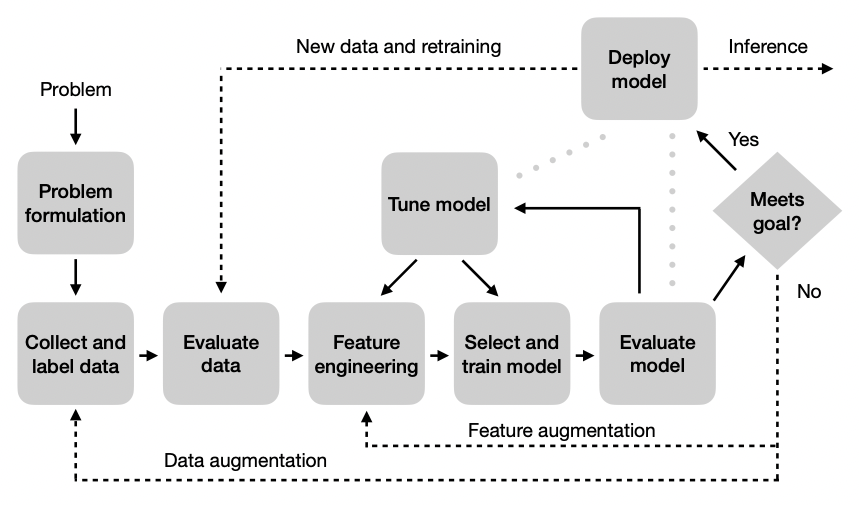

# Problem formulation

This exercise is about **Price Prediction** in the leisure industry, namely Airbnb rental prices in Lisbon, considering a particular timeframe. The goal is to predict the price of a rental given some of the features of the accommodation. In particular, given its number of the bedrooms.

The data to be used relates to AirBnB listings in Lisbon during a few months of 2017 (http://tomslee.net/airbnb-data-collection-get-the-data). 

The functional requirements for the Spark program you are about to create are as follows:

1. Read the dataset and carry out tasks of data cleasing and preparation, so ending up with a preprocessed dataset suitable for ML use. Among other procedures, tasks to be executed are:
    * to select an appropriate subset of columns of interest for ML analysis;
    * to remove outliers, e.g. nulls and extreme values;
    * fill in missing numerical values whenever appropriate.
    
    All this implies a proper understanding of the data, kind of exploratory data analysis, both textual/numerical and visual.
2. Build a simple linear regression model focussing on just predicting the `price` given the number of `bedrooms`. 
3. Apply the model to data not yet used by the model and evaluate the predictions.


The **data schema** of the dataset is the following:


**Column description**


|Column     | Description |
|:---:|:---:|
| **room_id** | A unique number identifying an Airbnb listing. The listing has a URL on the Airbnb web site of http://airbnb.com/rooms/room_id |
| **host_id** | A unique number identifying an Airbnb host. The host’s page has a URL on the Airbnb web site of http://airbnb.com/users/show/host_id |
| **room_type** | One of “Entire home/apt”, “Private room”, or “Shared room” |
| **borough** | A subregion of the city or search area for which the survey is carried out. |
| **neighborhood**  |Likewise borough: a subregion of the city or search area for which the survey is carried out. For cities that have both, a neighbourhood is smaller than a borough. For some cities there is no neighborhood information. |
| **reviews** | The number of reviews that a listing has received. Airbnb has said that 70% of visits end up with a review, so the number of reviews can be used to estimate the number of visits. Note that such an estimate will not be reliable for an individual listing (especially as reviews occasionally vanish from the site), but over a city as a whole it should be a useful metric of traffic. |
| **overall_satisfaction** | The average rating (out of five) that the listing has received from those visitors who left a review. |
| **accommodates**  | The number of guests a listing can accommodate. |
| **bedrooms** |  The number of bedrooms a listing offers. |
| **price** |  The price (in US dollars) for a night stay. In early surveys, there may be some values that were recorded by month. |
| **minstay** |  The minimum stay for a visit, as posted by the host. |
| **name** |  A description/marketing message about the listing. |
| **latitude** |  The latitude of the listing as posted on the Airbnb site. |
| **longitude** |  The longitude of the listing as posted on the Airbnb site: this may be off by a few hundred metres. |
    
*Notice*: location as indicated by latitude and longitude may be off by a few metres.


In [52]:
# If we need to install some packages, e.g. matplotlib

# ! pip3 install matplotlib
# ! pip3 install seaborn

In [53]:
# Some imports 

import os 

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Useful visualization functions

Some functions that we can use to plot data but as Python dataframes.

**Disclaimer**: these functions are broadly distributed among users. Further adjustments are needed and/or advisable. Feel free to use your own plotting functions.

In [54]:
def plotHistogram(df, xcol, huecol):
    sns.histplot(data=df, x=xcol, hue=huecol, multiple="stack")

In [55]:
def plotScatter(df, x, y, hue):
    
    sns.set_theme(style="whitegrid")

    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    g = sns.relplot(
        data=df,
        x=x, y=y,
        hue=hue,
        palette=cmap, sizes=(10, 200),
    )
    g.set(xscale="log", yscale="log")
    g.ax.xaxis.grid(True, "minor", linewidth=.25)
    g.ax.yaxis.grid(True, "minor", linewidth=.25)
    g.despine(left=True, bottom=True)

In [56]:
def plotScatterMatrix(df, huecol):
    sns.pairplot(data=df, hue=huecol)

In [57]:
def plotCorrelationMatrix1(df):
    # compute the correlation matrix
    corr = df.corr()

    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [58]:
def plotCorrelationMatrix2(df):
    # compute a correlation matrix and convert to long-form
    corr_mat = df.corr().stack().reset_index(name="correlation")
    # draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=corr_mat,
        x="level_0", y="level_1", hue="correlation", size="correlation",
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 250), size_norm=(-.2, .8),
    )

    # tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")

# Collect and label data

## Data ingestion

In [59]:
! pwd 
! ls -la

/home/big/Abd/ABD/Aulas/Aula_04
total 14068
drwxrwxr-x 4 big big     4096 Mar 11 03:38 .
drwxrwxr-x 6 big big     4096 Mar 11 02:47 ..
-rwxrwxr-x 1 big big 13882237 Mar 11 02:47 airbnb-lisbon-2017Q2toQ3.csv
drwxr-xr-x 2 big big     4096 Mar 11 03:27 clean-airbnb-lisbon-2017
drwxrwxr-x 2 big big     4096 Mar 11 02:48 .ipynb_checkpoints
-rwxrwxr-x 1 big big   501609 Mar 11 03:38 Spark-III-ML-Pipeline.ipynb


In [60]:
! head -n 1 airbnb-lisbon-2017Q2toQ3.csv
! tail -n 1 airbnb-lisbon-2017Q2toQ3.csv

",2017-04-18 04:00:58.350513,38.719848999999996,-9.131454,0101000020E610000055DB4DF04D4322C077871403245C4340!,2017-04-18 04:00:58.352914,38.718990000000005,-9.131687,0101000020E6100000E09D7C7A6C4322C0551344DD075C4340;;;C4340;;;;0;;0;;;;;;;;;;;;";;;5B4340";;;;;;,81934885,Entire home/apt,,Lisbon,,Estrela,0,0.0,6,1.0,,109.0,,Butler The Sailor - Lisbon boat,2017-04-18 09:31:45.144369,38.702692,-9.172414999999999,0101000020E610000000AE64C7465822C09694BBCFF1594340;; Basilica & BOAT"",2017-04-18 08:47:42.698316,38.712201,-9.158424,0101000020E610000092CD55F31C5122C0D9960167295B4340";;889B5B4340;;o Alto,2017-04-18 07:44:58.202292,38.710646000000004,-9.151211,0101000020E6100000469737876B4D22C04084B872F65A4340;;tle Hill,2017-04-18 07:28:13.571367,38.714546999999996,-9.135441,0101000020E61000003813D385584522C03B3AAE46765B4340;;E995B4340;;26047999999999,0101000020E6100000D2730B5D894022C0B2D991EA3B5B4340";;2017-04-18 05:57:32.500337,38.735237,-9.150350999999999,0101000020E610000080D767CEFA4C22C092E7

In [61]:
# some Spark related imports we will use hereafter

import sys

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [62]:
# build a SparkSession instance if one does not exist. Notice that we can only have one per JVM

# build our own SparkSession
spark = SparkSession\
    .builder\
    .appName("AirBnB")\
    .config("spark.sql.shuffle.partitions",6)\
    .getOrCreate()

In [63]:
# read the dataset 
# this time we will be using pyspark.sql.DataFrameReader.csv

datapath = "airbnb-lisbon-2017Q2toQ3.csv"

df_raw = spark.read.csv(datapath, header="true", inferSchema="true", sep=',')

## Columns to keep

In [64]:
# check the data - schema and count

df_raw.printSchema()
df_raw.show(2, vertical=True)
df_raw.count()

root
 |-- room_id: string (nullable = true)
 |-- survey_id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- overall_satisfaction: string (nullable = true)
 |-- accommodates: string (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minstay: string (nullable = true)
 |-- name: string (nullable = true)
 |-- last_modified: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location;;: string (nullable = true)

-RECORD 0------------------------------------
 room_id              | 5803348              
 survey_id            | 1079                 
 host_id              | 29676067          

64421

In [65]:
# let us get rid of some troubling columns for good

df_raw = df_raw.drop("location;;")
df_raw.printSchema()
df_raw.show(2, vertical=True)

root
 |-- room_id: string (nullable = true)
 |-- survey_id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- overall_satisfaction: string (nullable = true)
 |-- accommodates: string (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minstay: string (nullable = true)
 |-- name: string (nullable = true)
 |-- last_modified: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: double (nullable = true)

-RECORD 0------------------------------------
 room_id              | 5803348              
 survey_id            | 1079                 
 host_id              | 29676067             
 room_type            | Shared room   

# Evaluate data

Let us have some understanding about the data, with some exploratory data analysis based on descriptive statistics alongside visualizations (the latter if data justifies at this stage)

In [66]:
# check the columns, one by one, with focus on statistics and distinct values

columns = df_raw.columns
print(columns)
print("details")
for cl in columns:
    df_raw.describe(cl).show()
print("distinct")
for cl in columns:
    df_raw.select(cl).distinct().show(10)

['room_id', 'survey_id', 'host_id', 'room_type', 'country', 'city', 'borough', 'neighborhood', 'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'bathrooms', 'price', 'minstay', 'name', 'last_modified', 'latitude', 'longitude']
details
+-------+--------------------+
|summary|             room_id|
+-------+--------------------+
|  count|               64421|
|   mean|1.0369137667670943E7|
| stddev|   5969922.393140589|
|    min|"10008719,1079,23...|
|    max|     VanLifeDiaries"|
+-------+--------------------+

+-------+--------------------+
|summary|           survey_id|
+-------+--------------------+
|  count|               64369|
|   mean|  1262.5420944203036|
| stddev|   145.1841228510153|
|    min|  """"Hoteldarte ...|
|    max|zona + luxuosa ca...|
+-------+--------------------+

+-------+-------------------+
|summary|            host_id|
+-------+-------------------+
|  count|              64380|
|   mean| 3.55949773371781E7|
| stddev|3.681345715077899E7|
|    min|  

+--------+
| room_id|
+--------+
|13844212|
|  349975|
|17953842|
|17954348|
|14568376|
|12070760|
| 5725814|
|17786062|
| 7776066|
|11319185|
+--------+
only showing top 10 rows

+--------------------+
|           survey_id|
+--------------------+
|                1079|
| central and quiet""|
|             5 Pax""|
|            lisboa""|
|                null|
|               luz""|
|       river view!""|
|5 ROOMS UP TO 17 ...|
|    luxury in Bica""|
| 6 rooms flat w/ ...|
+--------------------+
only showing top 10 rows

+--------------------+
|             host_id|
+--------------------+
|            15212100|
|             1466881|
|            46550307|
|            49576492|
|            12771657|
|             1489229|
|            72951043|
|            73826302|
|             4452933|
|2017-04-18 11:30:...|
+--------------------+
only showing top 10 rows

+------------------+
|         room_type|
+------------------+
|38.710609000000005|
|         38.712964|
|         38.775077

### Data of interest
We may just want to deal with certain columns of the data, and having proper data types

In [67]:
# it looks like we will drop the following columns as 

# a) we do not want them
# b) apparent numeric data may be useful but data quality is poor (e.g. see min, max) 
#    that we are far from repairing it 

# From describe:
# 'room_id', - string
# 'survey_id', - string
# 'host_id', - string
# 'room_type', - string
# 'country', - string
# 'city', - string
# 'borough', - double !!
# 'neighborhood', - string
# 'reviews', - double
# 'overall_satisfaction', - double
# 'accommodates', - string
# 'bedrooms', - number
# 'bathrooms', - nulls
# 'price', - double
# 'minstay', - nulls
# 'name', - string
# 'last_modified', - string
# 'latitude', - string
# 'longitude' - double


cols_to_drop = ["country","city","borough","neighorhood","accommodates","bathrooms","minstay","last_modified","latitude","longitude"]

cols_interest = [x for x in columns if x not in cols_to_drop] 
cols_interest

['room_id',
 'survey_id',
 'host_id',
 'room_type',
 'neighborhood',
 'reviews',
 'overall_satisfaction',
 'bedrooms',
 'price',
 'name']

In [68]:
df_raw_interest = df_raw.select(cols_interest)

In [69]:
# check columns of interest: schema, contents and stats
df_raw_interest.printSchema()
df_raw_interest.show(10)
columns = df_raw.columns
for cl in cols_interest:
    df_raw.describe(cl).show()

root
 |-- room_id: string (nullable = true)
 |-- survey_id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- overall_satisfaction: string (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- price: double (nullable = true)
 |-- name: string (nullable = true)

+--------+---------+--------+-----------+--------------+-------+--------------------+--------+-----+--------------------+
| room_id|survey_id| host_id|  room_type|  neighborhood|reviews|overall_satisfaction|bedrooms|price|                name|
+--------+---------+--------+-----------+--------------+-------+--------------------+--------+-----+--------------------+
| 5803348|     1079|29676067|Shared room|  Misericordia|     19|                 5.0|     1.0| 19.0|Bunk with a view ...|
| 5823046|     1079|29676067|Shared room|  Misericordia|     35|                 4.5|     1.0| 14.

# Feature Engineering

Now we have to prepare data in a way that it can be properly used by ML algorithms, which includes the selection and extraction of features, as well as dealing with poor data quality if that is the case

In [70]:
# Fixing data types of columns of interest if necessary
# to do so, we can apply `cast` with the wanted type to the column at stake

# from above, it appears the following columns may accommodate some fixing
# |-- reviews: string (nullable = true)
# |-- overall_satisfaction: string (nullable = true)

# Importantly: we prefer not using integers but doubles instead. 
# The reason to do so is that some Spark's algorithms require doubles (apart from precision)

# Note: probably there are reasons why the DataFrame shows such incongruences. 
# One should look at the origin of the problems, prior to collecting data


print('df_raw_test')
df_raw_test = (df_raw_interest
                         .withColumn('name',column('name').cast(DoubleType()))
                        )

df_raw_test.printSchema()
df_raw_test.describe('name').show()

print('df_raw_interest_fixed')
df_raw_interest_fixed = (df_raw_interest
                         .withColumn('reviews',column('reviews').cast(DoubleType()))
                         .withColumn('overall_satisfaction',column('overall_satisfaction').cast(DoubleType()))
                        )
df_raw_interest_fixed.printSchema()
[df_raw_interest_fixed.count(), df_raw_test.count()]

df_raw_test
root
 |-- room_id: string (nullable = true)
 |-- survey_id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- overall_satisfaction: string (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- price: double (nullable = true)
 |-- name: double (nullable = true)

+-------+----+
|summary|name|
+-------+----+
|  count|   5|
|   mean| 3.0|
| stddev| 0.0|
|    min| 3.0|
|    max| 3.0|
+-------+----+

df_raw_interest_fixed
root
 |-- room_id: string (nullable = true)
 |-- survey_id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- reviews: double (nullable = true)
 |-- overall_satisfaction: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- price: double (nullable = true)
 |-- name: string (nullable = true)



[64421, 64421]

In [71]:
# numeric and non numeric (string) columns

double_cols = [x.name for x in df_raw_interest_fixed.schema.fields if x.dataType == DoubleType()]
non_double_cols = [x for x in cols_interest if x not in double_cols]

# we could have indicated the columns explicitly ...

[double_cols, non_double_cols]

[['reviews', 'overall_satisfaction', 'bedrooms', 'price'],
 ['room_id', 'survey_id', 'host_id', 'room_type', 'neighborhood', 'name']]

### Data cleasing
Once data of interest is established, with proper data types, the goal now is to get a clean dataset so we can proceed with our analysis. In particular, we will look at
* Nulls
* Extreme values

#### Nulls
We can handle null values in different ways. 
For example:
* Drop any records that contain nulls
* Numeric:
  * Replace them with mean/median/zero/etc.
* Categorical:
  * Replace them with the mode
  * Create a special category for null
* Use of techniques designed to impute missing values, like Spark's Imputer
 
Notice that sometimes there are nulls for some reason. For example, it may signify that a column needs to be computed in a particular mode, or predicted. 

But if there is any setting, it is important considering to add and additional field stating the case (may be needed further down the analysis). In particular, when imputation techniques are used.

In [72]:
# A brute-force solution: remove rows where at least one of the columns is null or NaN value
# we could have just considered a subset of columns 
# .na.drop(subset=["onlyColumn", ...])
# and then use Imputer to fill in the remaining

df_clean = df_raw_interest_fixed.dropna()

# check the sizes, just to make sure we can move on
[df_raw_interest_fixed.count(), df_clean.count()]

[64421, 54172]

In [73]:
# check the columns again, one by one
for cl in df_clean.columns:
    df_clean.describe(cl).show()

+-------+--------------------+
|summary|             room_id|
+-------+--------------------+
|  count|               54172|
|   mean|1.0207359954570627E7|
| stddev|    5964628.17552834|
|    min|            10006255|
|    max|              999276|
+-------+--------------------+

+-------+------------------+
|summary|         survey_id|
+-------+------------------+
|  count|             54172|
|   mean|1269.9647788525438|
| stddev|145.85540462560823|
|    min|              1079|
|    max|              1480|
+-------+------------------+

+-------+-------------------+
|summary|            host_id|
+-------+-------------------+
|  count|              54172|
|   mean|3.547068626982574E7|
| stddev|3.651841718930906E7|
|    min|          100004433|
|    max|           99983650|
+-------+-------------------+

+-------+---------------+
|summary|      room_type|
+-------+---------------+
|  count|          54172|
|   mean|           null|
| stddev|           null|
|    min|Entire home/apt|
|    

#### Outliers
We should get rid of some outliers that may exist in the data, by setting some value boundaries in respect to certain columns 

In [74]:
# Let us take a look as it stands now. For that, we use summary(), one column by one

for cl in df_clean.columns: 
    df_clean.select(cl).summary().show()


+-------+--------------------+
|summary|             room_id|
+-------+--------------------+
|  count|               54172|
|   mean|1.0207359954570627E7|
| stddev|    5964628.17552834|
|    min|            10006255|
|    25%|           4807897.0|
|    50%|         1.1131142E7|
|    75%|         1.5465033E7|
|    max|              999276|
+-------+--------------------+

+-------+------------------+
|summary|         survey_id|
+-------+------------------+
|  count|             54172|
|   mean|1269.9647788525438|
| stddev|145.85540462560823|
|    min|              1079|
|    25%|            1148.0|
|    50%|            1228.0|
|    75%|            1352.0|
|    max|              1480|
+-------+------------------+

+-------+-------------------+
|summary|            host_id|
+-------+-------------------+
|  count|              54172|
|   mean|3.547068626982574E7|
| stddev|3.651841718930906E7|
|    min|          100004433|
|    25%|          6092464.0|
|    50%|        2.1402831E7|
|    75%

In [75]:
# there are some numeric limits to uphold. For example, let us check max price

df_plot = df_clean.select('price','bedrooms').toPandas()

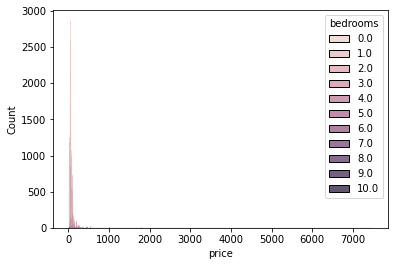

In [76]:
# and visually
plotHistogram(df_plot,'price','bedrooms')

In [77]:
# number of price outliers, say above 1000

df_clean.filter(df_clean.price > 1000).count()

178

In [78]:
# the final data to process

df_clean = df_clean.filter(df_clean.price <= 1000)

df_clean.printSchema()

# Further cleaning procedures can be applied 
# We leave such decisions for you

root
 |-- room_id: string (nullable = true)
 |-- survey_id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- reviews: double (nullable = true)
 |-- overall_satisfaction: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- price: double (nullable = true)
 |-- name: string (nullable = true)



#### Saving the clean data of interest

In [79]:
# save the clean DataFrame to a file for future use, just in case

# this time we are going to use the parquet format, so commom in Spark 
cleanfilename = "clean-airbnb-lisbon-2017"
df_clean.write.mode("overwrite").parquet(cleanfilename)

# check in your running directory if that was accomplished
! ls -la
# and later on, we can use spark.read.parquet() to load the file

total 14020
drwxrwxr-x 4 big big     4096 Mar 11 03:41 .
drwxrwxr-x 6 big big     4096 Mar 11 02:47 ..
-rwxrwxr-x 1 big big 13882237 Mar 11 02:47 airbnb-lisbon-2017Q2toQ3.csv
drwxr-xr-x 2 big big     4096 Mar 11 03:41 clean-airbnb-lisbon-2017
drwxrwxr-x 2 big big     4096 Mar 11 02:48 .ipynb_checkpoints
-rwxrwxr-x 1 big big   451253 Mar 11 03:40 Spark-III-ML-Pipeline.ipynb


In [80]:
! ls -la clean-airbnb-lisbon-2017

total 1248
drwxr-xr-x 2 big big   4096 Mar 11 03:41 .
drwxrwxr-x 4 big big   4096 Mar 11 03:41 ..
-rw-r--r-- 1 big big 672200 Mar 11 03:41 part-00000-53c9965c-080e-4392-b882-9225e9cf3f9c-c000.snappy.parquet
-rw-r--r-- 1 big big   5260 Mar 11 03:41 .part-00000-53c9965c-080e-4392-b882-9225e9cf3f9c-c000.snappy.parquet.crc
-rw-r--r-- 1 big big 569989 Mar 11 03:41 part-00001-53c9965c-080e-4392-b882-9225e9cf3f9c-c000.snappy.parquet
-rw-r--r-- 1 big big   4464 Mar 11 03:41 .part-00001-53c9965c-080e-4392-b882-9225e9cf3f9c-c000.snappy.parquet.crc
-rw-r--r-- 1 big big      0 Mar 11 03:41 _SUCCESS
-rw-r--r-- 1 big big      8 Mar 11 03:41 ._SUCCESS.crc


#### Final  overview
After establishing the clean data, let us get an overview about what we have achieved, with some statistics and in particulat visualizations.

In [81]:
# check some columns e.g. resp vs weight; 
# Correlation needs vectors so we convert to vector column first

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=double_cols, outputCol=vector_col)
df_vector = assembler.transform(df_clean).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).head()
print("Pearson correlation matrix:\n" + str(matrix[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        ,  0.41559846, -0.04267971, -0.10713192],
             [ 0.41559846,  1.        ,  0.02818783, -0.13236428],
             [-0.04267971,  0.02818783,  1.        ,  0.49775075],
             [-0.10713192, -0.13236428,  0.49775075,  1.        ]])


In [82]:
# convert to Pandas the DataFrame with the numeric columns set above, 
# just for visualization purposes

df_plot = df_clean.select(double_cols).toPandas()

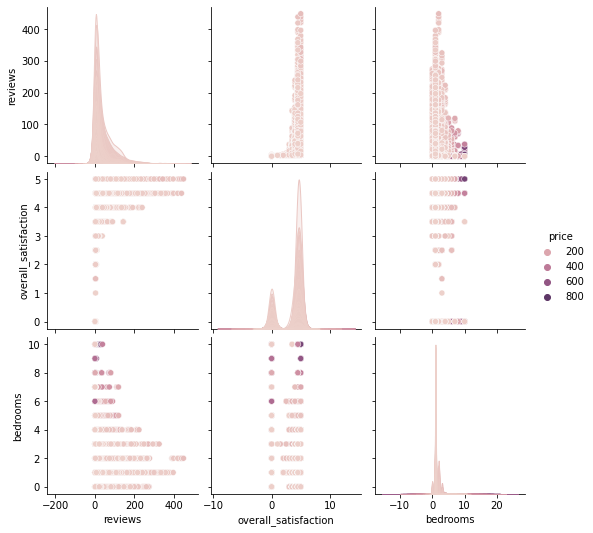

In [83]:
# a plot 
plotScatterMatrix(df_plot,'price')

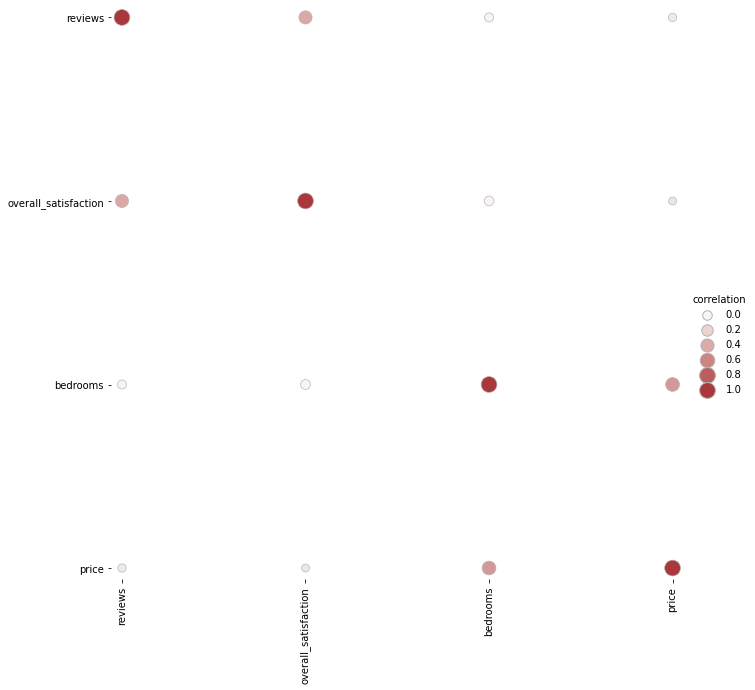

In [84]:
# plotting correlations
plotCorrelationMatrix2(df_plot)

#### Clear some objects from memory

If some objects are no further needed, we should delete them now

In [85]:
del df_raw, df_raw_interest, df_raw_interest_fixed, df_plot
del df_raw_test

# Select and train model

Given the clean dataset we obtained, we can now start to train and test a model which can be used then to predict new data instances. The steps are as follows:

1. Split the dataset into two groups: `train` and `test`
2. Build a simple linear regression model with focus on just predicting the `price` given the number of `bedrooms`. 
3. Apply the model to `test` group and figure out how it performs.

**Notice: caching parts of data**

It is a good idea to have parts of the dataset that is going to be heavily used by ML algorithms in cache so it makes accesses faster (but we should not have many in cache!)

## Train/test split

The step of creating a ML model means we should keep some part of our data in the dark.
Standard split is 80/20. 

Notice that if the test part is too low, then the model will memorize the data so it will reach an overfit situation.
That would be bad as it no longer have data to evaluate how well it will generalize to unseen data.

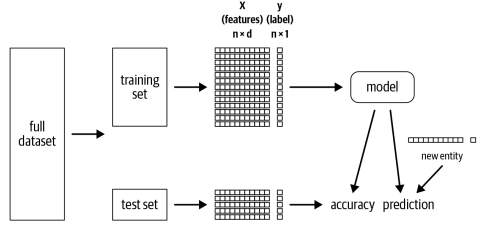   

In [87]:
# train/test split
#
# some aspects to consider:
# 1. data has to be split randomly (data shuffling
# 2. we must set a seed due to reproducibility issues 
#    so to achieve consistent results. And what about 42? 
# 3. different configuration of cluster affects the split. If we really want 
#    to guarantee reproducibility, we have to store the outcome once and then 
#    use it as needed.

df_train, df_test = df_clean.randomSplit([0.8,0.2],seed=42)

# caching data ... but just the training part
df_train.cache()

# print the number of rows in each part
print(f"There are {df_train.count()} rows in the training set and {df_test.count()} in the test set")

There are 43273 rows in the training set and 10721 in the test set


## Feature transformation

Similarly to other ML algorithms, linear regression requires that all input features are contained within a single vector. Therefore we need a transformation.

To do so we will use the `VectorAsAssembler` transformer.

Transformers accept a DataFrame as input and return a new one with one or more columns appended to it, using a `transform()` method following rule-based transformations - they do not learn from the data. Notice that they are lazilly evaluated.

In [88]:
# recall the two columns under analysis, price and bedrooms, and show a summary

df_train.select("price", "bedrooms").summary().show()

# keep in mind those numbers, in particular the min, max values

+-------+-----------------+------------------+
|summary|            price|          bedrooms|
+-------+-----------------+------------------+
|  count|            43273|             43273|
|   mean|77.34598941603309|1.5229819980126176|
| stddev|66.44147418395725|1.0287442424055182|
|    min|             10.0|               0.0|
|    25%|             43.0|               1.0|
|    50%|             62.0|               1.0|
|    75%|             90.0|               2.0|
|    max|            986.0|              10.0|
+-------+-----------------+------------------+



In [89]:
# get the vector assembler and subsequent train

vec_assembler = VectorAssembler(inputCols=["bedrooms"], outputCol="features")
vec_df_train = vec_assembler.transform(df_train)

# show the content of the columns bedrooms, features and price
vec_df_train.select("bedrooms", "features", "price").show(10)

+--------+--------+-----+
|bedrooms|features|price|
+--------+--------+-----+
|     1.0|   [1.0]| 70.0|
|     1.0|   [1.0]| 72.0|
|     1.0|   [1.0]| 75.0|
|     1.0|   [1.0]| 77.0|
|     1.0|   [1.0]| 77.0|
|     1.0|   [1.0]| 38.0|
|     1.0|   [1.0]| 39.0|
|     1.0|   [1.0]| 38.0|
|     1.0|   [1.0]| 39.0|
|     1.0|   [1.0]| 39.0|
+--------+--------+-----+
only showing top 10 rows



## Linear regression model
Once we have the vector assembler in place, then we can use the `LinearRegression` estimator (the algorithm) to build the model. As an estimator, it accepts a DataFrame as input and returns a model. This DataFrame input is going to be the output of the transformer.

The estimators learn parameters from the data, have a `.fit()` method and are immediately evaluated.

In [90]:
# returns a transformer that is the linear regression model

lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(vec_df_train)

22/03/17 10:07:48 WARN Instrumentation: [f1d74689] regParam is zero, which might cause numerical instability and overfitting.
22/03/17 10:07:48 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


## Inspect the model

Having learned the parameters, the transformer can applied them to new data points in order to generate predictions. Let us check such parameters, `coefficients` and `intercept`.

In [92]:
m =  np.around(lr_model.coefficients, decimals=2)
b =  np.around(lr_model.intercept,decimals=2)

# print the linear regression line

print(f"The formula for the linear regression line is: \tprice = {m[0]} * bedrooms + {b}")

The formula for the linear regression line is: 	price = 32.44 * bedrooms + 27.94


# Evaluate model

Let us evaluate the regression model

## Baseline model

In [93]:
# computing the average price of the training dataset

avg_price = float(df_train.select(avg("price")).first()[0])
df_pred = df_train.withColumn("avg_price_prediction", lit(avg_price))
avg_price

77.34598941603309

In [94]:
# show bedrooms, price and avg_price_prediction
df_pred.select("bedrooms","price","avg_price_prediction").show(50)

+--------+-----+--------------------+
|bedrooms|price|avg_price_prediction|
+--------+-----+--------------------+
|     1.0| 70.0|   77.34598941603309|
|     1.0| 72.0|   77.34598941603309|
|     1.0| 75.0|   77.34598941603309|
|     1.0| 77.0|   77.34598941603309|
|     1.0| 77.0|   77.34598941603309|
|     1.0| 38.0|   77.34598941603309|
|     1.0| 39.0|   77.34598941603309|
|     1.0| 38.0|   77.34598941603309|
|     1.0| 39.0|   77.34598941603309|
|     1.0| 39.0|   77.34598941603309|
|     1.0| 20.0|   77.34598941603309|
|     1.0| 20.0|   77.34598941603309|
|     1.0| 24.0|   77.34598941603309|
|     1.0| 25.0|   77.34598941603309|
|     1.0| 25.0|   77.34598941603309|
|     1.0|208.0|   77.34598941603309|
|     1.0|208.0|   77.34598941603309|
|     1.0|159.0|   77.34598941603309|
|     1.0|196.0|   77.34598941603309|
|     1.0|159.0|   77.34598941603309|
|     1.0|192.0|   77.34598941603309|
|     1.0|184.0|   77.34598941603309|
|     1.0| 60.0|   77.34598941603309|
|     1.0| 7

In [95]:
# model accuracy

evaluator = RegressionEvaluator(predictionCol="avg_price_prediction", labelCol="price", metricName="rmse")

print(f"The RMSE for predicting the average price is: {evaluator.evaluate(df_pred):.2f}")

The RMSE for predicting the average price is: 66.44


## Testing the model using a pipeline

It is time to apply the model built to the test set. But, again, we have to prepare the data like we did for training, with the help of a vector assembler.

Fortunately, there are `pipelines` available, which are useful in a sense that we specify the stages we want the data to pass and the rest is up to Spark. And pipelines are estimators.

So we will reuse stages specified before.

In [97]:
pipeline = Pipeline(stages=[vec_assembler, lr_model])

# get the model (as transformer)
pipeline_model = pipeline.fit(df_train)

Since the pipeline model is a transformer, we can easily apply it to the testing data.

In [98]:
df_prediction = pipeline_model.transform(df_test)

# show the columns worth to be looked at

df_prediction.select("bedrooms","features","price","prediction").show(10)
df_prediction.columns

+--------+--------+-----+------------------+
|bedrooms|features|price|        prediction|
+--------+--------+-----+------------------+
|     1.0|   [1.0]| 72.0|60.380997914995504|
|     1.0|   [1.0]| 79.0|60.380997914995504|
|     1.0|   [1.0]| 39.0|60.380997914995504|
|     1.0|   [1.0]| 19.0|60.380997914995504|
|     1.0|   [1.0]|159.0|60.380997914995504|
|     1.0|   [1.0]|197.0|60.380997914995504|
|     1.0|   [1.0]| 73.0|60.380997914995504|
|     1.0|   [1.0]| 96.0|60.380997914995504|
|     2.0|   [2.0]| 68.0| 92.81995674246225|
|     1.0|   [1.0]| 49.0|60.380997914995504|
+--------+--------+-----+------------------+
only showing top 10 rows



['room_id',
 'survey_id',
 'host_id',
 'room_type',
 'neighborhood',
 'reviews',
 'overall_satisfaction',
 'bedrooms',
 'price',
 'name',
 'features',
 'prediction']

### Visual analysis
Plotting the `price` versus `prediction` obtained above.

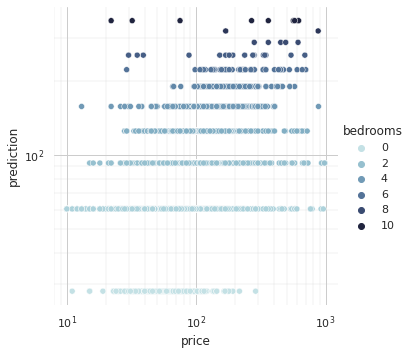

In [99]:
# plots
df_plot=df_prediction.toPandas()
plotScatter(df_plot,"price","prediction","bedrooms")

## Saving the model

In [100]:
# We can save the model and/or pipeline for further use

lr_model.save("regression-model")

pipeline.save("pipeline-regression-model")

# later on, it can be loaded anywhere


In [101]:
! ls -la

total 14080
drwxrwxr-x 6 big big     4096 Mar 17 10:21 .
drwxrwxr-x 6 big big     4096 Mar 11 02:47 ..
-rwxrwxr-x 1 big big 13882237 Mar 11 02:47 airbnb-lisbon-2017Q2toQ3.csv
drwxr-xr-x 2 big big     4096 Mar 11 03:41 clean-airbnb-lisbon-2017
drwxrwxr-x 2 big big     4096 Mar 11 02:48 .ipynb_checkpoints
drwxr-xr-x 4 big big     4096 Mar 17 10:21 pipeline-regression-model
drwxr-xr-x 4 big big     4096 Mar 17 10:21 regression-model
-rwxrwxr-x 1 big big   506174 Mar 17 10:20 Spark-III-ML-Pipeline.ipynb


# Tune model

**Clearly predicting price based just on number of bedrooms was not a wise decision.**

**How can we move forward? We leave the task to you!**

# Additional exercise

Once the previous exercise has been completed, create a new notebook with similar implementation but taken into consideration the following:
1. Apply extra rules in order to obtain a better clean dataset.
2. Adapt the linear regression model but considering a different column for the target label, as well a different set of columns as features, **including categorical features**. (check One-Hot encoding in Chapter 10 of the book Learning Spark)

# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* Spark: The Definitive Guide - Big Data Processing Made Simple, 1st Ed. B. Chambers and M. Zaharia. O'Reilly, 2018
* http://spark.apache.org/docs/latest/ml-guide.html
* https://docs.python.org/3/